# How I prompt VLMs in 2025 (Gemini)

In this notebook, I'll showcase how I prompt multimodal models, also called Vision-Language-Models (VLMs) in case they take images/video as input. Gemini is by default native multimodal.

We are going to use the serverless [Gemini API](https://ai.google.dev/gemini-api/docs). This means that you only need to pay for the input and output tokens, you're not paying for the hosting of the model.

## Set-up environment

Let's start by installing the necessary libraries. This notebook uses the [Google GenAI SDK](https://ai.google.dev/gemini-api/docs) as well as 🤗 [Datasets](https://huggingface.co/docs/datasets/en/index).

In [ ]:
!pip install -q google-genai datasets

## Load dataset

To illustrate how to effectively prompt Gemini, we need some data. Here I use the [CORD-v2 dataset](https://huggingface.co/datasets/naver-clova-ix/cord-v2) available on Hugging Face. It's a document AI dataset containing Indonesian food receipts along with a ground truth parsing.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

As can be seen, the dataset contains 3 splits, one for training, validation and testing. Don't worry, we're not going to train anything here (just prompting). Let's take a look at the first training example. It contains an image along with a ground truth, which is super long if you would print it.

In [ ]:
dataset["train"][0].keys()

dict_keys(['image', 'ground_truth'])

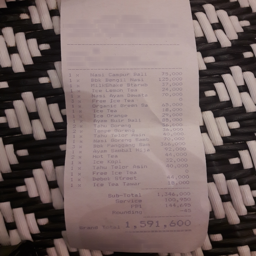

In [ ]:
example_image = dataset["train"][0]["image"]
example_image.resize((256, 256))

We can convert the `ground_truth` string into a Python dictionary using the `ast.literal_eval` [module](https://docs.python.org/3/library/ast.html). It's handy to convert strings into respective Python objects. We'll take the "gt_parse" key from the dictionary:

In [ ]:
import ast

example_ground_truth = dataset["train"][0]["ground_truth"]

ast.literal_eval(example_ground_truth)["gt_parse"]

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

Great! So this is what we want the model to output given a receipt image. It's a JSON containing 3 keys, "menu", "sub_total" and "total".

Note that technically it's not valid JSON yet, as for that we need to replace all single quotes by double quotes.

## Define response format

Next we'll define what we want the model to output exactly given a receipt image. As LLMs cannot directly output dictionaries but rather text, we'll make the model output the following format:

"""
\```json

\<actual-json>

```
"""

This will allow us to parse the JSON from the model's response using a regular expression. Below we write a function which allow us to convert ground truth examples from the dataset into this format.

In [ ]:
import ast

def convert_to_expected_response(text: str):
  """Convert a ground truth response to a format
  we expect the LLM to output."""

  # convert to dictionary
  text = ast.literal_eval(text)["gt_parse"]

  # replace all single quotes by double quotes
  # to make it valid JSON
  text = str(text).replace("'", '"')

  # convert to expected format
  json_text = f"""
```json
{text}
```
"""

  return json_text.strip()

Let's apply it on our example:

In [ ]:
convert_to_expected_response(example_ground_truth)

'```json\n{"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price": 

Let's define a function which allows us to parse it back to a dictionary:

In [ ]:
import json
import re


def parse_json_section(section_content: str) -> dict:
    """
    Extract and parse JSON from a section's content.

    Args:
        section_content (str): Content of section containing JSON

    Returns:
        dict: Parsed JSON object
    """
    # Find content between triple backticks
    json_match = re.search(r"```json\n(.*?)```", section_content, re.DOTALL)
    if not json_match:
        return section_content

    json_str = json_match.group(1).strip()
    return json.loads(json_str)

Let's verify our function on the formatted example:

In [ ]:
parse_json_section(convert_to_expected_response(example_ground_truth))

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## System and user prompt

Next it's time to define the system prompt (which defines how the LLM should behave) and the user prompt (which defines how each new receipt image should be processed).

As can be seen, we include the response format in the system prompt. I don't know what's the best here, you could definitely also experiment with putting it in the user prompt. Refer to Google's [prompt strategies guide](https://ai.google.dev/gemini-api/docs/prompting-strategies) for more info.

In [ ]:
system_prompt = """You are an expert at parsing Indonesian receipts from shops and restaurants.
You can effective extract the individual menu items, subtotal and total price from receipts.
Format your response as JSON, like so:
```json
<your-response>
```
Make sure to output valid JSON.
"""

user_prompt = """Extract the individual menu items, subtotal and total price from the following receipt:
"""

## Add few-shot examples

This is the most important part! This uniquely defines how I typically prompt Gemini.

Whenever processing a new input (like in our case, a receipt image), I'll make sure to give the model 10 to 15 similar input-output examples.

I see many people add few-shot examples in the final user prompt - please don't do this! Rather, make sure to send alternating messages of type "user" and "assistant" (or "model" in the case of Gemini) to the API.

This is because models are trained for multi-turn conversations this way. You let the user take a turn (with a message of role "user"), then the model (with a message of role "assistant" or "model"), then the user, and so on. Underneath, the model receives special tokens which indicate the start and end of each user/assistant message. Hence this ensures that the model will respect the format of the examples, when you give it a new one.

In other words, with 10 few-shot examples, we'll send 10 alternating "user" and "model" messages to the API before we let the model process the next one.

This is inspired by the [Many-Shot In-Context Learning in Multimodal Foundation Models](https://huggingface.co/papers/2405.09798) paper by Stanford. It shows that the performance of LLMs/multimodal models improves drastically the more few-shots you give it (and this is especially the case for Gemini). They go as far as adding 1000 few-shot examples to the prompt (of course, that would encounter a lot more token usage).

<img src="https://huggingface.co/datasets/nielsr/paper-few-shots/resolve/main/Screenshot%202025-04-20%20at%2013.25.12.png"
alt="drawing" width="600"/>

<small> Performance improves the more few-shots you give to the models. Taken from the <a href="https://huggingface.co/papers/2405.09798">original paper.</a> </small>

In our case, we'll take the first 10 images and their ground truths as our few-shots.

In [ ]:
example_images = dataset["train"][:10]["image"]
example_responses = [convert_to_expected_response(ground_truth) for ground_truth in dataset["train"][:10]["ground_truth"]]

Let's verify one:

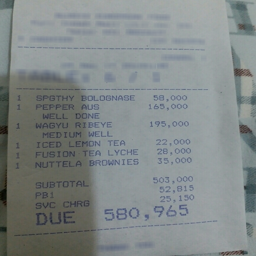

'```json\n{"menu": [{"nm": "SPGTHY BOLOGNASE", "cnt": "1", "price": "58,000"}, {"nm": "PEPPER AUS", "cnt": "1", "price": "165,000", "sub": {"nm": "WELL DONE"}}, {"nm": "WAGYU RIBEYE", "cnt": "1", "price": "195,000", "sub": {"nm": "MEDIUM WELL"}}, {"nm": "ICED LEMON TEA", "cnt": "1", "price": "22,000"}, {"nm": "FUSION TEA LYCHE", "cnt": "1", "price": "28,000"}, {"nm": "NUTTELA BROWNIES", "cnt": "1", "price": "35,000"}], "sub_total": {"subtotal_price": "503,000", "service_price": "25,150", "tax_price": "52,815"}, "total": {"total_price": "580,965"}}\n```'

In [ ]:
display(example_images[1].resize((256, 256)))
example_responses[1]

We'll start by initializing the genai SDK client.

In [ ]:
from google import genai

client = genai.Client(api_key="your-gemini-api-key") # create one as explained here: https://ai.google.dev/gemini-api/docs/api-key

Next we respect the API to send the few-shots as alternating "user" and "model" messages to the API, before we add our new query. The Gemini API uses specific Content, Part, File and FileData classes to prepare these.

In [ ]:
from google.genai.types import Content, File, FileData, GenerateContentConfig, Part
from PIL import Image


def upload_image(image: Image) -> File:
  filepath = "temp.jpg"
  image.save(filepath)
  file = client.files.upload(file=filepath)
  return Part(file_data=FileData(mime_type=file.mime_type, file_uri=file.uri))


# define user prompt
text_part = Part(text=user_prompt)


def create_user_message(image: Image) -> Content:
  file_part = upload_image(image)

  return Content(role="user", parts=[file_part, text_part])

contents = []

# add few-shots
for example_image, example_response in zip(example_images, example_responses):
    user_message = create_user_message(image=example_image)
    contents.append(user_message)
    assistant_message = Content(role="model", parts=[Part(text=example_response)])
    contents.append(assistant_message)

# add new query
# let's take an image from the test set
test_image = dataset["test"][1]["image"]
user_message = upload_image(image=test_image)
contents.append(user_message)
print(len(contents))

21


Finally it's time to process it! Note that we now have 21 messages ("contents" as the Gemini API calls it), namely 20 alternating user-assistant messages for our 10 few-shot examples, and one for the new-to-be-processed receipt image.

In [ ]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=GenerateContentConfig(
        system_instruction=system_prompt,
    ),
    contents=contents,
)
print(response.text)

```json
{"menu": [{"nm": "J.STB PROMO", "price": "17500"}, {"nm": "Y.B.BAT", "price": "46000"}, {"nm": "Y.BASO PROM", "price": "27500"}], "total": {"total_price": "91000", "cashprice": "91000"}}
```


Let's parse the response:

In [ ]:
parsed_response = (parse_json_section(response.text))
parsed_response

{'menu': [{'nm': 'J.STB PROMO', 'price': '17500'},
  {'nm': 'Y.B.BAT', 'price': '46000'},
  {'nm': 'Y.BASO PROM', 'price': '27500'}],
 'total': {'total_price': '91000', 'cashprice': '91000'}}

Let's compare that to the ground truth and display the original receipt:

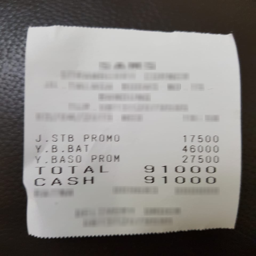

In [ ]:
display(dataset["test"][1]["image"].resize((256, 256)))

In [ ]:
import ast

ast.literal_eval(dataset["test"][1]["ground_truth"])["gt_parse"]

{'menu': [{'nm': 'J.STB PROMO', 'price': '17500'},
  {'nm': 'Y.B.BAT', 'price': '46000'},
  {'nm': 'Y.BASO PROM', 'price': '27500'}],
 'total': {'total_price': '91000', 'cashprice': '91000'}}

## Potential improvements: finding better few-shot examples

The example above showcased how we used 10 (receipt image, JSON ground truth) pairs to be passed in the prompt each time we want the model to parse a new receipt.

Of course, it could be that we haven't chosen the "best" few-shots given our budget of 10 few-shot examples, we just took the first 10 of the training set. My strategy here is typically to pick the 10 hardest/best representative examples, so as to make sure the model gets the best possible context to parse a new receipt.

One thing you could do to find these is collect a test set on which you quantify the performance (with metrics like Levensthein edit-distance which I also used in my [Donut fine-tuning notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb)), and compare various combinations of few-shots so as to pick the best ones.

## Potential improvements: structured output

One way to improve this could be to leverage the [Structured Outputs](https://ai.google.dev/gemini-api/docs/structured-output?lang=python) feature of the Gemini API. It allows to pass a [Pydantic Model](https://docs.pydantic.dev/1.10/usage/models/) (a bit similar to a Python dataclass) which the LLM is constrained to. For open-source models, this can be achieved with frameworks like [Outlines](https://github.com/dottxt-ai/outlines). Open-source inference engines like [vLLM](https://docs.vllm.ai/en/latest/features/structured_outputs.html), [TGI](https://huggingface.co/docs/text-generation-inference/en/conceptual/guidance) and [SGLang](https://docs.sglang.ai/backend/structured_outputs.html) also support structured outputs, ensuring that the model always respects the format you want it to output.

The dataset specification of CORD, the dataset we're using, can be found [here](https://github.com/clovaai/cord?tab=readme-ov-file#data-specification-for-the-whole-dataset). As can be seen from the specification, there are broad categories defined in each JSON:

- menu
- void menu
- sub total
- void total
- total.

Each of those categories then has specific subfields, e.g. the "menu" category has the name of the menu, the total price of the menu, etc.

Let's take a look at each of the few-shots we're using:

In [ ]:
for response in example_responses:
  print(parse_json_section(response).keys())

dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'sub_total', 'total'])
dict_keys(['menu', 'total'])
dict_keys(['menu', 'sub_total', 'total'])


Each of them except one has 3 fields, "menu", "sub_total" and "total". So it seems that the authors of CORD chose to not complete a field in case it's not present on the receipt.

Let's take a closer look at one specific example:

In [ ]:
parse_json_section(example_responses[0])

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

The "menu" category has a list of menu items, each with a name ("nm"), quantity ("cnt") and price.

The "sub_total" category has fields for the subtotal price, service price, tax price and an "etc" field.

The "total" category includes a "total_price" field.

For the sake of illustration, let's define a Pydantic schema which we could use for this use case. Let's restrict ourselves to 3 main categories, "menu", "sub_total" and "total", and use many Optional fields so the model doesn't have to complete them if they're not applicable for a given receipt.

In [ ]:
from pydantic import BaseModel
from typing import Optional


class MenuItem(BaseModel):
  nm: str
  cnt: int
  price: float


class SubTotal(BaseModel):
  subtotal_price: float
  discount_price: Optional[float] = None
  subtotal_count: Optional[int] = None
  service_price: Optional[float] = None
  thersvc_price: Optional[float] = None
  tax_price: Optional[float] = None
  tax_and_service: Optional[float] = None
  etc: Optional[str] = None


class Total(BaseModel):
  total_price: float
  total_etc: Optional[str] = None
  cashprice: Optional[float] = None
  changeprice: Optional[float] = None
  creditcardprice: Optional[float] = None
  emoneyprice: Optional[float] = None
  menutype_cnt: Optional[int] = None
  menuqty_cnt: Optional[int] = None


class Parsing(BaseModel):
  menu: list[MenuItem]
  total: Total
  sub_total: Optional[SubTotal] = None

Next we can pass the Parsing class to the response schema of the LLM API.

In [ ]:
from pprint import pprint

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=contents,
    config={
        'response_mime_type': 'application/json',
        'response_schema': Parsing,
    },
)
# Use the response as a JSON string.
pprint(response.text)

('{"menu": [{"nm": "J.STB PROMO", "cnt": 0, "price": 17500.00}, {"nm": '
 '"Y.B.BAT", "cnt": 0, "price": 46000.00}, {"nm": "Y.BASO PROM", "cnt": 0, '
 '"price": 27500.00}], "total": {"total_price": 91000.00, "cashprice": '
 '91000.00}}')


We can convert the string to a Python dictionary like so:

In [ ]:
ast.literal_eval(response.text)

{'menu': [{'nm': 'J.STB PROMO', 'cnt': 0, 'price': 17500.0},
  {'nm': 'Y.B.BAT', 'cnt': 0, 'price': 46000.0},
  {'nm': 'Y.BASO PROM', 'cnt': 0, 'price': 27500.0}],
 'total': {'total_price': 91000.0, 'cashprice': 91000.0}}

Great! Let's compare that to the ground truth:

In [ ]:
ast.literal_eval(dataset["test"][1]["ground_truth"])["gt_parse"]

{'menu': [{'nm': 'J.STB PROMO', 'price': '17500'},
  {'nm': 'Y.B.BAT', 'price': '46000'},
  {'nm': 'Y.BASO PROM', 'price': '27500'}],
 'total': {'total_price': '91000', 'cashprice': '91000'}}

This looks really good! As can be seen, the model also completed the "cnt" fiel for each menu item since we asked for it - we didn't put it as an optional field in the Pydantic schema above.

## Potential improvements: XML, Markdown

Several people have pointed out that JSON might not be the best output format to prompt LLMs, and that XML and Markdown work better/are more reliable.

The XML format could look like so:

```xml
<menu>
  <total>2947</total>
  <sub_total>4923</sub_total>
  <menu_items>
    <item>cheesecake</item>
    <item>cupcake</item>
    <item>brownie</item>
  </menu_items>
</menu>
```
This could then be parsed using a simple function like [this](https://github.com/anthropics/anthropic-cookbook/blob/4a7be656bd1a6e2149f9f1c40678dac379a857a7/patterns/agents/util.py#L30) which Anthropic included in their "How to build effective agents" guide.

Personally I had one use case where I kept getting JSON parsing issues, so I turned to Markdown which made the parsing easier. I haven't used XML myself yet for LLM use cases, but I'm curious if others have found more success with it.

A good read on JSON vs. XML for LLM parsing can be found [here](https://www.restack.io/p/tokenization-answer-comparing-llm-data-formats-yaml-vs-json-cat-ai).